In [40]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision import datasets, transforms

import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import copy
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]

In [53]:
class Params:
    def __init__(self):
        self.epochs = 10  #300
        self.num_users = 100
        self.frac = 0.1 # C
        self.local_ep = 5 # E
        self.local_bs = 10 # B
        self.bs = 128 
        self.lr = 0.01 
        self.momentum = 0.5 
        self.split =  ['user', 'sample'][0]
        
        self.model = ['mlp', 'cnn'][1] 
        self.kernel_num = 9 
        self.kernel_sizes = "3,4,5" 
        self.norm = ["batch_norm", "layer_norm", "None"][0] 
        self.num_filters = 32 
        self.max_pool = True 
        
        self.dataset = ["mnist", "cifar10"][0] 
        self.iid = True 
        self.num_classes = 10 
        self.num_channels = 3 if self.dataset == "cifar10" else 1
        self.gpu = 0
        self.stopping_rounds = 10
        self.verbose = True
        self.seed = 1773
        self.all_clients = False

        self.device = torch.device('cuda:{}'.format(self.gpu) if torch.cuda.is_available() and self.gpu != -1 else 'cpu')

params = Params()
        

In [54]:
class MLP(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        self.layer_input = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.dropout()
        self.layer_hidden = nn.Linear(dim_hidden, dim_out)

    def forward(self, x):
        x = x.view(-1, x.shape[1]*x.shape[-2]*x.shape[-1])
        x = self.layer_input(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_hidden(x)
        return x

class CNNMnist(nn.Module):
    def __init__(self, params):
        super(CNNMnist, self).__init__() 
        self.conv1 = nn.Conv2d(params.num_channels, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.conv2_drop = nn.Dropout2d() 
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, params.num_classes) 
    
    def forward(self, x): 
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) 
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3]) 
        x = F.relu(self.fc1(x)) 
        x = F.dropout(x, training=self.training) 
        x = self.fc2(x) 
        return x 

In [58]:
class ClassicalModel: 
    def __init__(self, params:Params): 
        self.params = params 
        torch.manual_seed(self.params.seed) 
        self.create_dataset() 
        self.model = CNNMnist(self.params).to(self.params.device) # MLP(dim_in=Len in, dim_hidden=64, dim out=self.params.num_class 
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.params.lr, momentum=self.params.momentum) 
        self.train_loss = [] 
        self.test_loss = []
        self.train_acc = []
        self.test_acc = []

        os.makedirs('runs', exist_ok=True) 
        os.makedirs('runs/classic', exist_ok=True) 
        os.makedirs(f'runs/classic/{self.params.dataset}', exist_ok=True) 
        os.makedirs(f'runs/classic/{self.params.dataset}/{self.params.model}', exist_ok=True) 
        self.dir = f'runs/classic/{self.params.dataset}/{self.params.model}'

    def create_dataset(self): 
        self.dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, 
                transform = transforms.Compose([ 
                    transforms.ToTensor(), 
                    transforms.Normalize((0.1307,), (0.3081,)) 
                ]))
        self.img_size = self.dataset_train[0][0].shape 
        self.train_loader = DataLoader(self.dataset_train, batch_size=self.params.bs, shuffle=True) 
        
        self.dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, 
                transform=transforms.Compose([  
                    transforms.ToTensor(), 
                    transforms.Normalize((0.1307,), (0.3081,)) 
                ]))
        self.test_loader = DataLoader(self.dataset_test, batch_size=self.params.bs, shuffle=False) 
        
    def train(self): 
        self.model.train() 
        batch_loss = []
        correct = 0 
        for batch_idx, (data, target) in enumerate(self.train_loader): 
            data, target = data.to(self.params.device), target.to(self.params.device) 
            self.optimizer.zero_grad() 
            output = self.model(data) 
            loss = F.cross_entropy(output, target) 
            loss.backward() 
            self.optimizer.step() 
            '''if self.params.verbose and batch idx % 1000 == 0: 
                print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {1.6f}'.format( 
                    self.epoch, batch idx * len(data), len(self.train_loader.dataset),
                    100 = batch idx/len(self.train loader), loss.item()))'''
            batch_loss.append(loss.item()) 
            
            self.model.eval() 
            y_pred = output.data.max(1, keepdim=True)[1] 
            correct += y_pred.eq(target.data.view_as (y_pred)).long().cpu().sum() 
        
        loss_avg = sum(batch_loss)/len(batch_loss) 
        acc_avg = 100*correct / len(self.train_loader.dataset) 
        if self.params.verbose: 
            print('Train loss:', loss_avg, "Train Acc: ", acc_avg.item()) 
        self.train_loss.append(loss_avg) 
        self.train_acc.append(acc_avg.item())

    def eval(self): 
        self.model.eval() 
        test_loss = 0 
        correct = 0 
        l = len(self.test_loader) 
        for idx, (data, target) in enumerate(self.test_loader): 
            data, target = data.to(self.params.device), target.to(self.params.device) 
            log_probs = self.model(data) 
            test_loss += F.cross_entropy (log_probs, target).item() 
            y_pred = log_probs.data.max(1, keepdim=True)[1]
            correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum() 
        
        test_loss /= len(self.test_loader.dataset) 
        test_acc = 100 * correct / len(self.test_loader.dataset) 
        if self.params.verbose: 
            print('Test set: Average loss: {:.4f} Accuracy: {}/{} ({:.2f}%)\n'.format( 
                test_loss, correct, len(self.test_loader.dataset), 
                test_acc)) 
        
        self.test_loss.append(test_loss) 
        self.test_acc.append(test_acc.item()) 
        
    def run(self): 
        for self.epoch in range(self.params.epochs): 
            print("Epoch: ", self.epoch) 
            self.train() 
            self.eval() 
        plt.figure() 
        plt.subplot(2, 1, 1) 
        plt.plot(range(len(self.train_loss)), self.train_loss, label='Train Loss', color = 'r') 
        plt.plot(range(len(self.test_loss)), self.test_loss, label='Test Loss', color = 'b') 
        plt.xlabel('Epochs') 
        plt.ylabel('Loss') 
        plt.title('Loss') 
        plt.legend() 
                   
        plt.subplot(2, 1, 2) 
        plt.plot(range(len(self.train_acc)), self.train_acc, label='Train Acc', color = 'r') 
        plt.plot(range(len(self.test_acc)), self.test_acc, label='Test Acc', color = 'b') 
        plt.xlabel('Epochs') 
        plt.ylabel('Accuracy') 
        plt.title('Accuracy') 
        plt.legend()
        plt.ylim((96,100)) 
        
        plt.savefig(f'{self.dir}/info.png') 
        plt.savefig(f'{self.dir}/info.pdf') 
        plt.show() 
                  
        train_loss_file = open(f'{self.dir}/train_loss.csv', 'w', newline ='') 
        with train_loss_file: 
            write = csv.writer(train_loss_file) 
            write.writerows([[item] for item in self.train_loss]) 
        
        train_acc_file = open(f'{self.dir}/train_acc.csv', 'w', newline ='') 
        with train_acc_file: 
            write = csv.writer(train_acc_file) 
            write.writerows([[item] for item in self.train_acc]) 
        
        test_loss_file = open(f'{self.dir}/test_loss.csv', 'w', newline ='') 
        with test_loss_file: 
            write = csv.writer(test_loss_file) 
            write.writerows([[item] for item in self.test_loss]) 
        
        test_acc_file = open(f'{self.dir}/test_acc.csv', 'w', newline ='') 
        with test_acc_file: 
            write = csv.writer(test_acc_file) 
            write.writerows([[item] for item in self.test_acc])

In [59]:
classic_model = ClassicalModel(params)

Epoch:  0
Train loss: 0.7919981751614796 Train Acc:  76.63999938964844
Test set: Average loss: 0.0017 Accuracy: 9374/10000 (93.74%)

Epoch:  1
Train loss: 0.19136046168646578 Train Acc:  94.46666717529297
Test set: Average loss: 0.0011 Accuracy: 9602/10000 (96.02%)

Epoch:  2
Train loss: 0.13022140653005668 Train Acc:  96.28500366210938
Test set: Average loss: 0.0007 Accuracy: 9725/10000 (97.25%)

Epoch:  3
Train loss: 0.10378679840057008 Train Acc:  97.038330078125
Test set: Average loss: 0.0006 Accuracy: 9757/10000 (97.57%)

Epoch:  4
Train loss: 0.08716183538828641 Train Acc:  97.48666381835938
Test set: Average loss: 0.0005 Accuracy: 9791/10000 (97.91%)

Epoch:  5
Train loss: 0.07846607121108755 Train Acc:  97.77666473388672
Test set: Average loss: 0.0005 Accuracy: 9810/10000 (98.10%)

Epoch:  6
Train loss: 0.07079173182484819 Train Acc:  97.95500183105469
Test set: Average loss: 0.0005 Accuracy: 9819/10000 (98.19%)

Epoch:  7
Train loss: 0.06386931039798044 Train Acc:  98.13999938

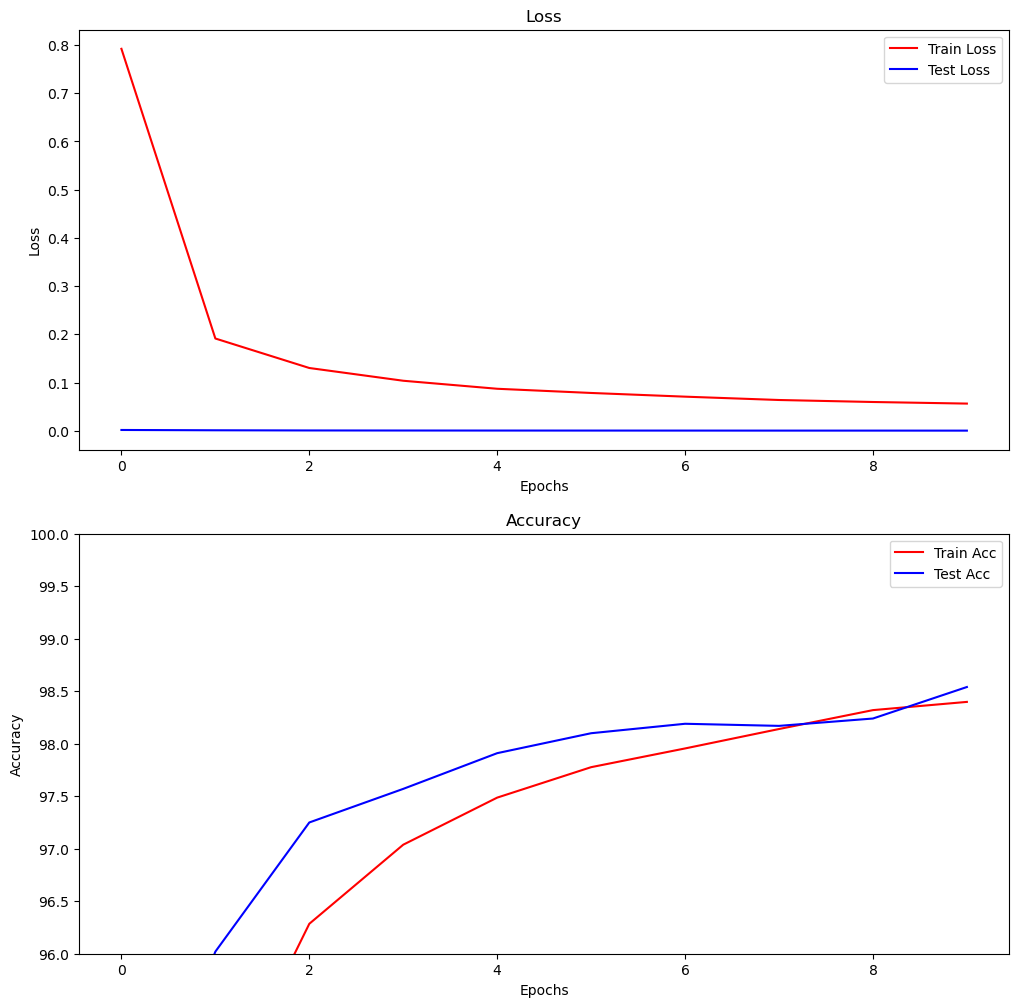

In [60]:
classic_model.run()

In [ ]:
class FederatedModel: 
    def __init__(self, params: Params): 
        self.params = params 
        torch.manual_seed(self.params.seed) 
        self.create_dataset() 
        self.model CNNMnist(self.params).to(self.params.device)# MLP(dim_in=len_in, dim_hidden=64, dim_out=self.params.num_class 
        self.glob_weights = self.model.state_dict() \
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.params.lr, momentum=self.params.momentum) 
        self.train_loss = [] 
        self.test_loss = [] 
        self.train_acc = [] 
        self.test_acc =[] 
        
        os.makedirs('runs', exist_ok=True) 
        os.makedirs('runs/federated', exist_ok=True) 
        os.makedirs(f'runs/federated/{self.params.dataset}', exist_ok=True) 
        os.makedirs(f'runs/federated/{self.params.dataset}/{self.params.model}', exist_ok=True) 
        self.dir = f'runs/federated/{self.params.dataset}/{self.params.model}' 
        
    def create dataset(self): 
        def mnist_iid(dataset, num_users): 
            num_items = int(len(dataset)/num_users) 
            dict_users, all_idxs = {}, [i for i in range(len(dataset))] 
            for i in range(num_users): 
                dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False)) 
                all_idxs = list(set(all_idxs) - dict_users[i]) 
            return dict_users

    def mnist_noniid(dataset, num_users): 
        num_shards, num_imgs = 200, 300 
        idx_shard = [i for i in range(num_shards)] 
        dict_users = {i: np.array([], dtypes='int64') for i in range(num_users)} 
        idxs = np.arange(num_shards*num_imgs) 
        labels = dataset.train_labels.numpy() 
        
        #sort Labels 
        idxs_labels = np.vstack((idxs, labels)) 
        idxs_labels = idxs_labels[:,idxs_labels[1,:].argsort()] 
        idxs = idxs_labels[0,:] 
        
        #divide and assign 
        for i in range(num_users): 
            rand_set = set(np.random.choice(idx_shard, 2, replaces False)) 
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set: 
                dict_users[i] = np.concatenate((dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0) 
        return dict_users 
        
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) 
    self.dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist) 
    self.dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist) 
    if self.params.iid: 
        self.dict_users = mnist_iid(self.dataset_train, self.params.num_users)
    else:  
        self.dict_users = mnist_noniid(self.dataset_train, self.params.num_users) 
    
    self.img_size = self.dataset_train[0][0].shape 

    class LocalUpdate(object): 
        def __init__(self, params, dataset=None, idxs=None): 
            self.params = params 
            self.loss_func = nn.CrossEntropyLoss()
            self.selected_clients = []
            self.ldr_train = DataLoader(self.DatasetSplit(dataset, idxs), batch_size=self.params.local_bs, shuffle=True)

        class DatasetSplit(Dataset): 
            def __init__(self, dataset, idxs): 
                self.dataset = dataset 
                self.idxs = list(idxs) 
            
            def __len__(self): 
                return lan(self.idxs) 
                
            def __getitem__(self, item): 
                image, label = self.dataset[self.idxs[item]] 
                return inage, label 
            
        
        def train(self, net): 
            net.train() 
            optimizer = torch.optin.SGD(net.parameters(), lr=self.params.lr, momentum=self.params.momentum) 
            epoch_loss = []
            epoch_acc = [] 
            for iter in range(self.params.local_ep): 
                batch_loss = [] 
                correct = 0 
                for batch_idx, (images, labels) in enumerate(self.ldr_train): 
                    images, labels = images.to(self.params.device), labels.to(self.params.device) 
                    net.zero_grad() 
                    log_probs = net(images) 
                    loss = self.loss_func(log_probs, labels) 
                    batch_loss.append(loss.item()) 
                    
                    y_pred = log_probs.data.max(1, keepdim=True)[1] 
                    correct += y_pred.eq(labels.data.view_as(y_pred)).long().cpu().sum().item()

                    loss.backward() 
                    optimizer.step() 
                epoch_loss.append(sum(batch_loss)/len(batch_loss)) 
                epoch_acc.append(correct/len(self.ldr_train.dataset)) 
            return net.state_dict(), sum_(epoch_loss) / len(epoch_loss), 100 * sum(epoch_acc) / len(epoch_acc) 
    
    def FedAvg(self, w): 
        w_avg = copy.deepcopy(w[0]) 
        for k in w_avg.keys(): 
            for i in range(1, len(w)): 
                w_avg[k] += w[i][k] 
            w_avg[k] = torch.div(w_avg[k], len(w)) 
        return w_avg 
    
    def eval(self): 
        self.model.eval() 
        test_loss = 0
        correct = 0 
        data_loader = DataLoader(self.dataset_test, batch_size=self.params.bs) 
        l = len(data_loader) 
        for idx, (data, target) in enumerate(data_loader): 
            if self.params.gpu != -1: 
                data, target = data.cuda(), target.cuda() 
            log_probs = self.model(data)
            test_loss += F.cross_entropy(log probs, target, reductions='sum').item() 
            y_pred = log_probs.data.max(1, keepdim=True)[1] 
            correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum() 
            
        test_loss /= len(data_loader.dataset) 
        accuracy = 100.00 * correct / len(data_loader.dataset) 
        if self.params.verbose: 
            print('Test set: Average loss: {:.4f} Accuracy: {}/{} ({.2f}%)\n'.format(
                test_loss, correct, len(data_loader.dataset), accuracy)) 
        
        self.test_loss.append(test_loss) 
        self.test_acc.append(accuracy.item()) 
        
    def run(self): 
        
        if self.params.all_clients: 
            print("Aggregation over all clients") 
            w_locals = [self.glob_weights for i in range(self.params.nus_users)] 
            
        for self.epoch in range(self.params.epochs): 
            self.model.train() 
            print("Epoch: ", self.epoch) 
            loss_locals = [] 
            acc_locals = []
            if not self.params.all_clients: 
                w_locals = [] 
            
            m = max(int(self.params.frac * self.params.num_users), 1) 
            idxs_users = np.random.choice(range(self.params.num_users), m, replace=False) 
            for idx in idxs_users: 
                local = self.LocalUpdate(params, dataset=self.dataset_train, idxs=self.dict_users[idx]) 
                w, loss, acc = local.train(net=copy.deepcopy(self.model).to(self.params.device)) 
                if self.params.all_clients: 
                    w_locals[idx] = copy.deepcopy(w)
                else:
              